# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import io
import os
import numpy as np
import scipy

In [2]:
PATH_TO_DATA = "data/"

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict(zip(self.word2vec.keys(), range(len(self.word2vec.keys()))))
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        #returns K most similar words of input; self.score  -  np.argsort
        
        #list of other words
        words = list(self.word2vec.keys())
        
        #list of consine similarities
        scores = np.vectorize(lambda x: self.score(w,x))(words)
        
        #sort the scores
        scores_sort_arg = np.argsort(scores)[::-1]
        
        #list of K most simlar words
        output = []
        i = 1
        for n in range(K):
            arg = scores_sort_arg[i]
            output = np.append(output,self.id2word[arg])
            i += 1
        return output

    def score(self, w1, w2):
        #returns cosine similarity between w1 and w2: np.dot  -  np.linalg.norm
        
        #word embeddings of w1 and w2
        w1_emb = self.word2vec[w1]
        w2_emb = self.word2vec[w2]
        
        #dot and norms
        w1_dot_w2 = w1_emb.dot(w2_emb)
        w1_emb_norm = np.linalg.norm(w1_emb)
        w2_emb_norm = np.linalg.norm(w2_emb)
        
        #cosine similarity of w1 and w2
        result = w1_dot_w2/(w1_emb_norm*w2_emb_norm)
        return result

In [4]:
#I have increased the value for nmax to 200000 to solve key errors 
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 200000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052403
paris france 0.7775108541288561
germany berlin 0.7420295235998392
['cats' 'kitty' 'kitten' 'feline' 'kitties']
['dogs' 'puppy' 'Dog' 'doggie' 'canine']
['dog' 'pooches' 'Dogs' 'doggies' 'canines']
['france' 'Paris' 'parisian' 'london' 'berlin']
['austria' 'europe' 'german' 'berlin' 'poland']


In [5]:
from math import log

class BoV():
    def __init__(self, w2v):
        self.w2v = w2v

    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        for sent in sentences:
            if idf is False:
                # mean of word vectors
                # append to sentemb the mean of word vectors that are in the sentence
                sentemb.append(np.mean([w2v.word2vec[w] for w in sent if w in w2v.word2vec], axis=0))
        
            else:
                # idf-weighted mean of word vectors
                sentemb.append(np.average([w2v.word2vec[w] for w in sent if w in w2v.word2vec], axis=0,
                                      weights = [idf[w] for w in sent if w in w2v.word2vec]))
    
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        keys = self.encode(sentences, idf)
        query = self.encode([s], idf)
        #list of scores of sentences
        scores = np.array([self.score(s,sent) for sent in sentences])

        #sort the scores
        scores_sort_arg = np.argsort(scores)[::-1]
        
        #list of K most simlar sentences
        output = []
        i = 1
        for n in range(K):
            arg = scores_sort_arg[i]
            output = np.append(output,sentences[arg])
            i += 1
            print(" ".join(sentences[arg]))

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
                
        #embeddings of s1 and s2
        s1_emb = self.encode([s1], idf)[0]
        s2_emb = self.encode([s2], idf)[0]
        
        #dot and norms
        s1_dot_s2 = s1_emb.dot(s2_emb)
        s1_emb_norm = np.linalg.norm(s1_emb)
        s2_emb_norm = np.linalg.norm(s2_emb)
        
        #cosine similarity of s1 and s2
        result = s1_dot_s2/(s1_emb_norm*s2_emb_norm)
        return result

    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf_occ = {}
        for sent in sentences:
             for w in set(sent):
                    idf_occ[w] = idf_occ.get(w, 0) + 1
        idf = {w: np.log10(len(sentences)/(n_occ)) for (w,n_occ) in idf_occ.items()}

        return  idf

In [6]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=100000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
sentences = []
with open('data/sentences.txt') as f:
    for i, line in enumerate(f):
        sent = line.rstrip().split()
        sentences.append( sent )
print('Found %s sentences' % len(sentences))

# Build idf scores for each word
idf = s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
print("\nBoV-mean:")
s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean
print("\nBoV-mean score",s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13]))

print("\nBoV-idf:")
s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf
print("\nBoV-idf score",s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))

Loaded 100000 pretrained word vectors
Found 150736 sentences

BoV-mean:
an african american man smiling .
a little african american boy and girl looking up .
an afican american woman standing behind two small african american children .
an african american man is sitting .
a girl in black hat holding an african american baby .

BoV-mean score 0.5726258859719607

BoV-idf:
an african american man smiling .
a little african american boy and girl looking up .
an afican american woman standing behind two small african american children .
an african american man is sitting .
a girl in black hat holding an african american baby .

BoV-idf score 0.43033788356459757


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [7]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

# TYPE CODE HERE

#Loading 50k first vectors of french dictionay
fr_w2v = {}
with io.open('data/wiki.fr.vec', encoding='utf-8') as f:
    next(f)
    for i, line in enumerate(f):
        word, vec = line.split(' ', 1)
        fr_w2v[word] = np.fromstring(vec, sep=' ')
        #only load 50k first vectors
        if i == 49999:
            break
print('fr_w2v is a dictionary with {} loaded French word vectors'.format(len(fr_w2v)))

#Loading 50k first vectors of English dictionay
en_w2v = {}
with io.open('data/wiki.en.vec', encoding='utf-8') as f:
    next(f)
    for i, line in enumerate(f):
        word, vec = line.split(' ', 1)
        en_w2v[word] = np.fromstring(vec, sep=' ')
        #only load 50k first vectors
        if i == 49999:
            break
print('en_v2v is a dictionary with  {} loaded English word vectors'.format(len(en_w2v)))


fr_w2v is a dictionary with 50000 loaded French word vectors
en_v2v is a dictionary with  50000 loaded English word vectors


In [8]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

# TYPE CODE HERE

#Initialize matrices X and Y
X, Y = [], []

# Go through all the words in the French vocabulary
for word in fr_w2v:
    #check if the word in also in the English Vocabulary
    if word in en_w2v:
        #when word is in both vocabs, add it to X & Y
        X.append(fr_w2v[word])
        Y.append(en_w2v[word])

#turn X and Y into numpy arrays
X, Y = np.array(X), np.array(Y)
print('Shape of X: {}'.format(np.ma.shape(X)))
print('Shape of Y: {}'.format(np.ma.shape(Y)))

Shape of X: (18970, 300)
Shape of Y: (18970, 300)


In [9]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

# TYPE CODE HERE

#matrix YXt = Y * transpose(X)
YXt = np.dot(np.transpose(Y),X)

#SVD of YXt
U, S, Vt = np.linalg.svd(YXt)

#optimal W
W = np.dot(U,Vt)
print("Shape of Matrix W:{}".format(np.ma.shape(W)))

Shape of Matrix W:(300, 300)


In [10]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

# TYPE CODE HERE

#Create dictionaries word2id and id2word (same as done in the definition of Word2vec in section 1)
fr_word2id = dict(zip(fr_w2v.keys(), range(len(fr_w2v.keys()))))
fr_id2word = {v: k for k, v in fr_word2id.items()}

en_word2id = dict(zip(en_w2v.keys(), range(len(en_w2v.keys()))))
en_id2word = {v: k for k, v in en_word2id.items()}

#Function to compute cosine similarity of two words w1 and w2
def score(w1, w2):
    return w1.dot(w2)/(np.linalg.norm(w1)*np.linalg.norm(w2))

#Function to Find K Enlish nearest neighbors of a French word w 
def translate_fr_to_en(w, K=5):
    
    #projecting the word w in the same space as English vocabulary
    #W is the transition matrix computed in question 3 (cell above)
    w_en = np.dot(W,fr_w2v[w])
    
    #list of scores 
    scores_en = np.array([score(w_en,w2) for w2 in en_w2v.values()])
    
    #sort the scores
    scores_en_sort_arg = np.argsort(scores_en)[::-1]
    
    #list of nearest neighbors
    output_en = []    
    for n in range(K):
        arg = scores_en_sort_arg[n+1]
        output_en = np.append(output_en,en_id2word[arg])
    
    return output_en

#Function to Find K French nearest neighbors of a English word w     
def translate_en_to_fr(w, K=5):
    #projecting the word w in the same space as French vocabulary
    #W_2 is the transition matrix for English -> French translation
    W_2 = np.linalg.inv(W)
    w_fr = np.dot(W_2,en_w2v[w])
    
    #list of scores 
    scores_fr = np.array([score(w_fr,w2) for w2 in fr_w2v.values()])
    
    #sort the scores
    scores_fr_sort_arg = np.argsort(scores_fr)[::-1]
    
    #list of nearest neighbors
    output_fr = []    
    for n in range(K):
        arg = scores_fr_sort_arg[n+1]
        output_fr = np.append(output_fr,fr_id2word[arg])
    
    return output_fr

#Testing the translator

print("\nFrench to English:")
fr_words = ["travailler", "voyage", "cheval", "amour", "aliment"]
for w in fr_words:
    translations_fr2en = translate_fr_to_en(w, K=5)
    print("5 best translations of {} are: {}".format(w, " ".join(translations_fr2en)))

print("\nEnglish to French")
en_words = ["work", "travel", "horse", "love", "food"]
for w in en_words:
    translations_en2fr = translate_en_to_fr(w, K=5)
    print("5 best translations of {} are: {}".format(w, " ".join(translations_en2fr)))


French to English:
5 best translations of travailler are: working work freelance collaborate apprenticeship
5 best translations of voyage are: trip voyages journeys voyage journeyed
5 best translations of cheval are: horses cheval horseman dressage hooves
5 best translations of amour are: unrequited affection longing amour affections
5 best translations of aliment are: cooked nutritional vegetables carbohydrates sucrose

English to French
5 best translations of work are: travail œuvre travailler travaille travaillera
5 best translations of travel are: voyages voyage voyager voyageant voyagent
5 best translations of horse are: horses cheval galop chevaux attelage
5 best translations of love are: amour lover lovers beautiful my
5 best translations of food are: aliments nourriture alimentaires alimentaire nutrition


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [11]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# TYPE CODE HERE

#Loading Train data
Y_train = []
sentences_train = []
with open('data/SST/stsa.fine.train', "r") as f:
    for line in f:
        splitted = line[:-1].split(" ")
        Y_train.append(splitted[0])
        sentences_train.append(splitted[1:])
        
print('Size of Y_train: {}'.format(len(Y_train)))
print('Size of sentences_train: {}'.format(len(sentences_train)))

#Loading Dev data
Y_dev = []
sentences_dev = []
with open('data/SST/stsa.fine.dev', "r") as f:
    for line in f:
        splitted = line[:-1].split(" ")
        Y_dev.append(splitted[0])
        sentences_dev.append(splitted[1:])
        
print('\nSize of Y_dev: {}'.format(len(Y_dev)))
print('Size of sentences_dev: {}'.format(len(sentences_dev)))


#Loading Test data
Y_test = []
sentences_test = []
with open('data/SST/stsa.fine.test.X', "r") as f:
    for line in f:
        splitted = line[:-1].split(" ")
        Y_test.append(splitted[0])
        sentences_test.append(splitted[1:])
        
print('\nSize of Y_test: {}'.format(len(Y_test)))
print('Size of sentences_test: {}'.format(len(sentences_test)))

Size of Y_train: 8544
Size of sentences_train: 8544

Size of Y_dev: 1101
Size of sentences_dev: 1101

Size of Y_test: 2210
Size of sentences_test: 2210


In [12]:
# 2 - Encode sentences with the BoV model above

# TYPE CODE HERE

#We use the crawl dictionary, as it performs better than the wiki dictionnary
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=100000)

#Call the BoV model defined in section 1
s2v = BoV(w2v)

#BoV-mean
train_emb = s2v.encode(sentences_train, idf=False)
dev_emb = s2v.encode(sentences_dev, idf=False)

#BoV-idf weighted
idf = s2v.build_idf(sentences_train+sentences_dev)
train_emb_idf = s2v.encode(sentences_train, idf=idf)
dev_emb_idf = s2v.encode(sentences_dev, idf=idf)

Loaded 100000 pretrained word vectors


In [13]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

# TYPE CODE HERE

#Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

## SEARCHING FOR BEST PARAMETER C

#BoV-mean

# Logistic Regression with l2 regularization
clf1 = LogisticRegression(penalty= 'l2')
# GridSearch to chose the parameter C of the estimator
search_C1 = GridSearchCV(estimator = clf1,scoring='accuracy',param_grid={'C' : np.linspace(0.01,1,30)})
search_C1.fit(np.concatenate([train_emb,dev_emb]), Y_train + Y_dev)
print('### BoV-mean ###')
print('The best parameter C is: {}'.format(search_C1.best_params_))
print('The corresponding score: {}'.format(search_C1.best_score_))

#BoV-idf weighted

# Logistic Regression with l2 regularization
clf2 = LogisticRegression(penalty= 'l2')
# GridSearch to chose the parameter C of the estimator
search_C2 = GridSearchCV(estimator = clf2,scoring='accuracy',param_grid={'C' : np.linspace(0.01,1,30)})
search_C2.fit(np.concatenate([train_emb_idf,dev_emb_idf]), Y_train + Y_dev)
print('\n### BoV-idf weighted ###')
print('The best parameter C is: {}'.format(search_C2.best_params_))
print('The corresponding score: {}'.format(search_C2.best_score_))

## THE BEST PARAMETER IS C = 0.55, with BoV-mean model (accuracy 0.433)
##                    AND C = 0.11 with BoV-idf weighted model (accuracy 0.429)

## PRODUCE PREDICTIONS : 

#BoV-mean with C = 0.55
clf3 = LogisticRegression(penalty= 'l2', C=0.55)
print("\n### BoV-mean ###")
clf3.fit(train_emb, Y_train)
print("Accuracy Score on train set: {}".format(clf3.score(train_emb, Y_train)))
print("Accuracy Score on dev set: {}".format(clf3.score(dev_emb, Y_dev)))

#BoV-idf weighted with C = 0.11
clf4 = LogisticRegression(penalty= 'l2', C=0.11)
print("\n### BoV-idf weighted ###")
clf4.fit(train_emb_idf, Y_train)
print("Accuracy Score on train set: {}".format(clf4.score(train_emb_idf, Y_train)))
print("Accuracy Score on dev set: {}".format(clf4.score(dev_emb_idf, Y_dev)))

C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  F

C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Meryem\Anacon

C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Meryem\Anacon

C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Meryem\Anacon

C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Meryem\Anacon

C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Meryem\Anacon

### BoV-mean ###
The best parameter C is: {'C': 0.5562068965517242}
The corresponding score: 0.43359253499222394


C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  F

C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Meryem\Anacon

C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Meryem\Anacon

C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Meryem\Anacon

C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Meryem\Anacon

C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Meryem\Anacon


### BoV-idf weighted ###
The best parameter C is: {'C': 0.11241379310344828}
The corresponding score: 0.4293416277864178

### BoV-mean ###


C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy Score on train set: 0.4794007490636704
Accuracy Score on dev set: 0.4359673024523161

### BoV-idf weighted ###


C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy Score on train set: 0.4681647940074906
Accuracy Score on dev set: 0.42052679382379654


In [14]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# TYPE CODE HERE

#produce the 2210 preductions

#Best Accuracy scores are obtained with Average Word Wevtors (BoV - mean)
#The parameter C that gives the best accuracy for BoV-mean is C = 0.55

#encoding test set
test_emb = s2v.encode(sentences_test, idf=False)

#Chosen Model
clf5 = LogisticRegression(penalty= 'l2', C=0.55)
clf5.fit(np.concatenate([train_emb,dev_emb]), Y_train + Y_dev)

predictions = clf5.predict(test_emb)

#save the output
with open('logreg_bov_y_test_sst.txt', "w", encoding="utf-8") as f:
    for x in predictions:
        f.write(str(x))
        f.write("\n") #to have "one line, one prediction"

C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [9]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [15]:
import keras

Using TensorFlow backend.


In [16]:
# 1 - Load train/dev/test sets of SST
PATH_TO_DATA = "../../data/"

# TYPE CODE HERE

#Loading Train data
Y_train = []
sentences_train = []
with open('data/SST/stsa.fine.train', "r") as f:
    for line in f:
        splitted = line[:-1].split(" ")
        Y_train.append(splitted[0])
        sentences_train.append(splitted[1:])
        
print('Size of Y_train: {}'.format(len(Y_train)))
print('Size of sentences_train: {}'.format(len(sentences_train)))

#Loading Dev data
Y_dev = []
sentences_dev = []
with open('data/SST/stsa.fine.dev', "r") as f:
    for line in f:
        splitted = line[:-1].split(" ")
        Y_dev.append(splitted[0])
        sentences_dev.append(splitted[1:])
        
print('\nSize of Y_dev: {}'.format(len(Y_dev)))
print('Size of sentences_dev: {}'.format(len(sentences_dev)))


#Loading Test data
Y_test = []
sentences_test = []
with open('data/SST/stsa.fine.test.X', "r") as f:
    for line in f:
        splitted = line[:-1].split(" ")
        Y_test.append(splitted[0])
        sentences_test.append(splitted[1:])
        
print('\nSize of Y_test: {}'.format(len(Y_test)))
print('Size of sentences_test: {}'.format(len(sentences_test)))

Size of Y_train: 8544
Size of sentences_train: 8544

Size of Y_dev: 1101
Size of sentences_dev: 1101

Size of Y_test: 2210
Size of sentences_test: 2210


In [17]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE

from keras.preprocessing.text import one_hot

#Create the list of words contained in training set
words_train = set([word for sentence in sentences_train for word in sentence])

#Increase of 25% the size of the vector in one_hot function to avoid collisions
n = round(len(words_train)*(1+0.25))

def text2int(sentences):
    '''Transform a list of sentences to a sequence of integers'''
    output = [one_hot(" ".join(sent), n) for sent in sentences]
    return output

# Transform train/dev/test sentences to sequence of integers
int_train = text2int(sentences_train)
int_dev = text2int(sentences_dev)
int_test = text2int(sentences_test)

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [18]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE
from keras.preprocessing.sequence import pad_sequences

#Maximum lenght of a sentence in each set
max_len_train = max([len(s) for s in int_train])
max_len_dev = max([len(s) for s in int_dev])
max_len_test = max([len(s) for s in int_test])

#maximum lenght
max_len = max(max_len_train, max_len_dev, max_len_test)
print("Maximum lenght of a sentence is {}".format(max_len))

#Padding
int_train_pad = pad_sequences(int_train, maxlen=max_len)
int_dev_pad = pad_sequences(int_dev, maxlen=max_len)
int_test_pad = pad_sequences(int_test, maxlen=max_len)

Maximum lenght of a sentence is 51


## 4.2 - Design and train your model

In [19]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.

# ADAPT CODE BELOW

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 32  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = round(len(words_train)*(1+0.25))  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout_W=0.2, dropout_U=0.2))
model.add(Dense(n_classes, activation='sigmoid'))

C:\Users\Meryem\Anaconda2\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, dropout=0.2, recurrent_dropout=0.2)`


In [20]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          663232    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 688,389
Trainable params: 688,389
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
bs = 64
n_epochs = 6

#Definition of Train & Validation datasets
x_train = int_train_pad
x_dev = int_dev_pad

from keras.utils.np_utils import to_categorical

y_train = to_categorical(Y_train)
y_dev = to_categorical(Y_dev)

#Fitting the model
history = model.fit(x_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(x_dev, y_dev), verbose=1)

#Plotting the model

import matplotlib.pyplot as plt

def plot_hist(history):
    plt.plot(history.history["acc"])
    plt.plot(history.history["val_acc"])
    plt.title("Accuracy on train/dev sets")
    plt.legend(["train", "dev"])
    plt.show()

plot_hist(history)

Train on 8544 samples, validate on 1101 samples
Epoch 1/6
8544/8544 [==============================] - 16s 2ms/step - loss: 1.5742 - acc: 0.2715 - val_loss: 1.5697 - val_acc: 0.2670
Epoch 2/6
8544/8544 [==============================] - 14s 2ms/step - loss: 1.5188 - acc: 0.3186 - val_loss: 1.5044 - val_acc: 0.3633
Epoch 3/6
8544/8544 [==============================] - 14s 2ms/step - loss: 1.3034 - acc: 0.4519 - val_loss: 1.3911 - val_acc: 0.3951
Epoch 4/6
8544/8544 [==============================] - 14s 2ms/step - loss: 1.0650 - acc: 0.5596 - val_loss: 1.4665 - val_acc: 0.3797
Epoch 5/6
8544/8544 [==============================] - 13s 1ms/step - loss: 0.8709 - acc: 0.6581 - val_loss: 1.6532 - val_acc: 0.3760
Epoch 6/6
8544/8544 [==============================] - 13s 1ms/step - loss: 0.7072 - acc: 0.7317 - val_loss: 1.7842 - val_acc: 0.3551


<Figure size 640x480 with 1 Axes>

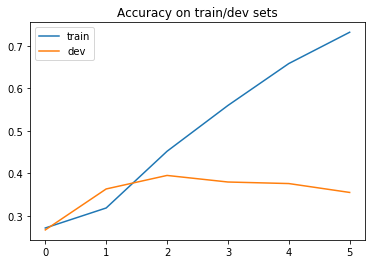

In [22]:
plot_hist(history)

In [23]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE

#Prediction
predictions = model.predict_classes(int_test_pad)

#saving the prediction
with open("logreg_lstm_y_test_sst.txt", "w", encoding="utf-8") as f:
    for x in predictions:
        f.write(str(x))
        f.write("\n")

## 4.3 -- innovate !

w2v_emb is a dictionary with  100000 loaded English word vectors
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_9 (Bidirection (None, 64)                85248     
_________________________________________________________________
dense_17 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 645       
Total params: 94,213
Trainable params: 94,213
Non-trainable params: 0
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/6
8544/8544 [==============================] - 24s 3ms/step - loss: 1.4977 - acc: 0.3284 - val_loss: 1.3496 - val_acc: 0.3760
Epoch 2/6
8544/854

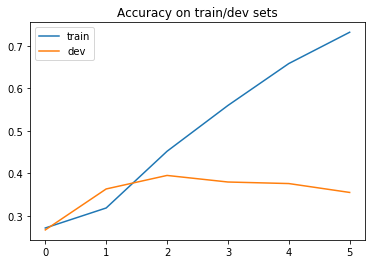

In [36]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE

########################### PRE-PROCESSING ####################################

# a) Loading a sequence of pretrained emeddings from 'crawl' data into a dictionary
w2v_emb = {}
with io.open('data/crawl-300d-200k.vec', encoding='utf-8') as f:
    next(f)
    for i, line in enumerate(f):
        word, vec = line.split(' ', 1)
        w2v_emb[word] = np.fromstring(vec, sep=' ')
        #only load 100k first vectors
        if i == 100000 - 1:
            break
print('w2v_emb is a dictionary with  {} loaded English word vectors'.format(len(w2v_emb)))

# b) Remove stopwords from data sets

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

StopWords = set(stopwords.words('english'))

def filter_stopwords(sentences):
    sentences_filtered = []
    for s in sentences:
        s_filtered = []
        for token in s:
            if token not in StopWords: 
                s_filtered.append(token)
        sentences_filtered.append(s_filtered)
    return sentences_filtered

X_train_filtered = filter_stopwords(sentences_train)
X_dev_filtered = filter_stopwords(sentences_dev)
X_test_filtered = filter_stopwords(sentences_test)

# c) encode datasets
def encode_dataset(sentences, len_seq = 34): 
    encoded = []
    for s in sentences:
        s_emb = []
        len_s = len(s)
        for i in range(len_seq):
            if i<len_s:
                w = s[i]
                if w in w2v_emb:
                    s_emb.append(w2v_emb[w])
                else:
                    s_emb.append(np.zeros(300))
            else:
                s_emb.append(np.zeros(300))
        encoded.append(s_emb)
    return np.array(encoded)

X_train_filtered_emb = encode_dataset(X_train_filtered)
X_dev_filtered_emb = encode_dataset(X_dev_filtered)
X_test_filtered_emb = encode_dataset(X_test_filtered)

# d) x_train, x_test_ x_dev
x_train = X_train_filtered_emb
x_dev = X_dev_filtered_emb
x_test = X_test_filtered_emb

# e) Y_train & Y_dev Dataset
from keras.utils.np_utils import to_categorical
y_train = to_categorical(Y_train)
y_dev = to_categorical(Y_dev)


########################### MODEL ####################################
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation, Bidirectional, Dropout

### MODEL ### 
model_2 = Sequential()
model_2.add(Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2), input_shape=(max_len_seq, 300,)))
model_2.add(Dense(128, activation="relu"))
model_2.add(Dropout(0.5))
model_2.add(Dense(5, activation="sigmoid"))
model_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model_2.summary())

bs = 64
n_epochs = 6
history_2 = model_2.fit(x_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(x_dev, y_dev), verbose=1)

import matplotlib.pyplot as plt

def plot_hist(history):
    plt.plot(history.history["acc"])
    plt.plot(history.history["val_acc"])
    plt.title("Accuracy on train/dev sets")
    plt.legend(["train", "dev"])
    plt.show()

plot_hist(history)

########################### PREDICTION ####################################

predictions = model_2.predict_classes(x_test)

#saving the prediction
with open("logreg_lstm_y_test_sst_2.txt", "w", encoding="utf-8") as f:
    for x in predictions:
        f.write(str(x))
        f.write("\n")